#### PySIR - Testing the SIRD model
#### Author: Lucas Vilas Boas Alves <lucas.vbalves@gmail.com>

In [1]:
import datetime
import pysir
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

from IPython.display import display, Markdown

In [2]:
pd.set_option('display.max_rows', 10)

# Definição das funções de apoio

### Função para cálculo do Fator de 2

In [3]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

### Função para geração de DataFrame com métricas de regressão

In [4]:
def get_metrics(y_true, y_pred):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
    return metrics

### Função para geração de DataFrame com métricas de regressão para cada região

In [5]:
def get_regions_metrics(y_true, y_pred):
    
    regions = list(y_true['region'].unique())
    regions_metrics = pd.DataFrame()
    
    for region in regions:
        y_true_region = y_true[y_true['region'] == region].drop('region', axis=1)
        y_pred_region = y_pred[y_pred['region'] == region].drop('region', axis=1)

        region_metrics = get_metrics(y_true_region, y_pred_region)
        avg_region_metrics = region_metrics.loc['Average':'Average', :]
        avg_region_metrics.index = [region]

        regions_metrics = pd.concat([regions_metrics, avg_region_metrics])
        regions_metrics = regions_metrics.sort_values(by='MSE')

    return regions_metrics

### Função para plotar gráficos de dispersão entre valores reais e preditos para cada horizonte de previsão

In [6]:
def plot_scatter(y_true, y_pred, title=''):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(5, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
        
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

### Função para plotar valores reais e preditos em cada horizonte de previsão

In [7]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(5, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

### Função para plotar métricas do modelo em cada horizonte de previsão

In [8]:
def plot_metrics(dict_metrics, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()

### Função para plotar a variação dos parâmetros ajustados do modelo SEIR ao longo do tempo

In [9]:
def plot_params(params_history, title=''):

    plt.figure(figsize=(15, 12))
    plt.suptitle(title, fontsize=14, y=0.93)

    time = list(range(1, len(params_history)+1))

    for col, param_name in enumerate(params_history.columns):

        plt.subplot(3, 2, col+1)
        plt.plot(time, params_history[param_name], marker='o', label=param_name)

        plt.title('Variação de {} ao longo do tempo'.format(param_name))
        plt.legend()
        plt.xlabel('Dias', fontsize=10)
        plt.ylabel(param_name, fontsize=10)
        plt.xticks(np.linspace(time[0], time[-1], num=6, dtype=int))

    plt.subplots_adjust(wspace=0.2, hspace=0.35)
    plt.show()

### Função para carregar nomes das regiões presentes nos dados do JHU

In [10]:
def get_region_names(data):
    
    confirmed = data[0]
    deaths = data[1]
    recovered = data[2]
    
    confirmed_regions = set(confirmed['Country/Region'].unique())
    deaths_regions = set(deaths['Country/Region'].unique())
    recovered_regions = set(recovered['Country/Region'].unique())
    
    all_regions = confirmed_regions.intersection(deaths_regions, recovered_regions)
    all_regions = list(all_regions)
    all_regions.sort()
    
    return all_regions

### Função para carregar dados do JHU de uma região específica

In [11]:
def get_single_region_data(data, region):
    
    region_names = get_region_names(data)
    
    if region not in region_names:
        print('get_single_region_data error: Region name not found!')
        return None
    
    confirmed = data[0]
    deaths = data[1]
    recovered = data[2]
    
    var_dict = {'confirmed': confirmed,
                'deaths': deaths,
                'recovered': recovered}

    region_data = pd.DataFrame()

    for var_name, var_global in zip(var_dict.keys(), var_dict.values()):
        
        var_region = var_global[var_global['Country/Region']==region]
        var_region = var_region.loc[:, '1/22/20':]
        var_region = var_region.sum()

        region_data[var_name] = var_region
        
    region_data.index = pd.to_datetime(region_data.index)
    
    # Select samples begining from the first confirmed case
    region_data = region_data[region_data['confirmed']>0]
    
    # Create column to count the number of days since the first confirmed case
    region_data['infection_days'] = np.arange(1, len(region_data)+1)
    
    # Insert region name
    region_data.insert(loc=0, column='region', value=region)
    
    return region_data

# Preparação dos dados

### Carregando dados populacionais mundiais

In [12]:
population_df = pd.read_csv('kaggle_pop_data/population_by_country_2020.csv')
population_df = population_df.drop(
    columns=['Yearly Change','Net Change',
             'Density (P/Km²)','Land Area (Km²)',
             'Migrants (net)','Fert. Rate', 'World Share']
)

### Selecionando população estimada do Brasil em 2020

In [13]:
brazil_pop = population_df[population_df['Country (or dependency)']=='Brazil']['Population (2020)'].values[0]

In [14]:
brazil_pop

212253150

### Diretórios dos arquivos com dados do JHU

In [15]:
confirmed_filename = 'jhu_data/time_series_covid19_confirmed_global.csv'
deaths_filename = 'jhu_data/time_series_covid19_deaths_global.csv'
recovered_filename = 'jhu_data/time_series_covid19_recovered_global.csv'

### Carregando dados do JHU

In [16]:
confirmed = pd.read_csv(confirmed_filename)
deaths = pd.read_csv(deaths_filename)
recovered = pd.read_csv(recovered_filename)

data = [confirmed, deaths, recovered]

### Selecionando dados do JHU para o Brasil e transformando-os em dados diários

In [17]:
brazil = get_single_region_data(data, 'Brazil')

brazil_daily = brazil.copy()
brazil_daily.loc[:,'confirmed':'recovered'] = brazil_daily.loc[:,'confirmed':'recovered'].diff()
brazil_daily.iloc[0, :] = brazil.iloc[0, :]

### Selecionando dados dos últimos 30 dias para ajustar modelo

In [18]:
x_brazil_daily = brazil_daily.copy()

In [19]:
x_brazil_daily

,region,confirmed,deaths,recovered,infection_days
2020-02-26,Brazil,1.0,0.0,0.0,1
2020-02-27,Brazil,0.0,0.0,0.0,2
2020-02-28,Brazil,0.0,0.0,0.0,3
2020-02-29,Brazil,1.0,0.0,0.0,4
2020-03-01,Brazil,0.0,0.0,0.0,5
...,...,...,...,...,...
2020-06-12,Brazil,25982.0,909.0,15158.0,108
2020-06-13,Brazil,21704.0,892.0,14313.0,109
2020-06-14,Brazil,17110.0,612.0,9705.0,110
2020-06-15,Brazil,20647.0,627.0,8568.0,111


### Criando dataset com dados futuros vazios

In [20]:
y_brazil_daily = brazil_daily.iloc[-20:, :].copy()
y_brazil_daily.loc[:, 'confirmed':'recovered'] = np.nan
y_brazil_daily.loc[:, 'infection_days'] = y_brazil_daily.loc[:, 'infection_days']+20
y_brazil_daily.index = y_brazil_daily.index + datetime.timedelta(days=20)

In [21]:
y_brazil_daily

,region,confirmed,deaths,recovered,infection_days
2020-06-17,Brazil,NaN,NaN,NaN,113
2020-06-18,Brazil,NaN,NaN,NaN,114
2020-06-19,Brazil,NaN,NaN,NaN,115
2020-06-20,Brazil,NaN,NaN,NaN,116
2020-06-21,Brazil,NaN,NaN,NaN,117
...,...,...,...,...,...
2020-07-02,Brazil,NaN,NaN,NaN,128
2020-07-03,Brazil,NaN,NaN,NaN,129
2020-07-04,Brazil,NaN,NaN,NaN,130
2020-07-05,Brazil,NaN,NaN,NaN,131


# Modelo SIRD

### Ajustando modelo SIRD aos dados de casos confirmados do Brasil

In [22]:
model = pysir.SIRD(brazil_pop)

begin = datetime.datetime.now()
print('Begin:', begin)

history = model.fit(x_brazil_daily)

end = datetime.datetime.now()
print('End:', end)

print('Time:', end-begin)

Begin: 2020-08-31 19:55:38.565397
End: 2020-08-31 19:57:14.357460
Time: 0:01:35.792063


### Parâmetros do modelo SIRD ajustados aos dados

In [23]:
model.params

{'beta': 0.45697887443621754,
 'T_inf': 2.135257022792577,
 'N_inf': 99.99282772449607,
 'T_death': 14.140991321415449,
 'cfr': 0.1834544740379953}

### Avaliando erro entre dados de treinamento e previsão do modelo com os parâmetros ajustados

In [24]:
loss = model.evaluate(x_brazil_daily)

In [25]:
print('MSE:', loss)

MSE: 16286796.674107144


### Fazendo previsões de casos confirmados no Brasil para os próximos 20 dias

In [26]:
y_pred_df = model.predict(x_brazil_daily, look_forward=20)

In [27]:
y_pred_df

,region,confirmed,deaths
113,Brazil,42705.0,1217.0
114,Brazil,45337.0,1291.0
115,Brazil,48127.0,1372.0
116,Brazil,51083.0,1456.0
117,Brazil,54213.0,1545.0
...,...,...,...
128,Brazil,103172.0,2953.0
129,Brazil,109251.0,3129.0
130,Brazil,115656.0,3314.0
131,Brazil,122403.0,3509.0


### Modelando compartimentos do modelo SIRD para 180 dias de epidemia no Brasil

In [28]:
solution = model.solve(n_days=180)

In [29]:
print('Suscetíveis no dia 180:', solution[0][179])
print('Infectados no dia 180:', solution[1][179])
print('Removidos no dia 180:', solution[2][179])
print('Mortos no dia 180:', solution[3][179])

Suscetíveis no dia 180: 188106634.0
Infectados no dia 180: 1967769.0
Removidos no dia 180: 21451024.0
Mortos no dia 180: 727723.0


### Plotando previsões do modelo

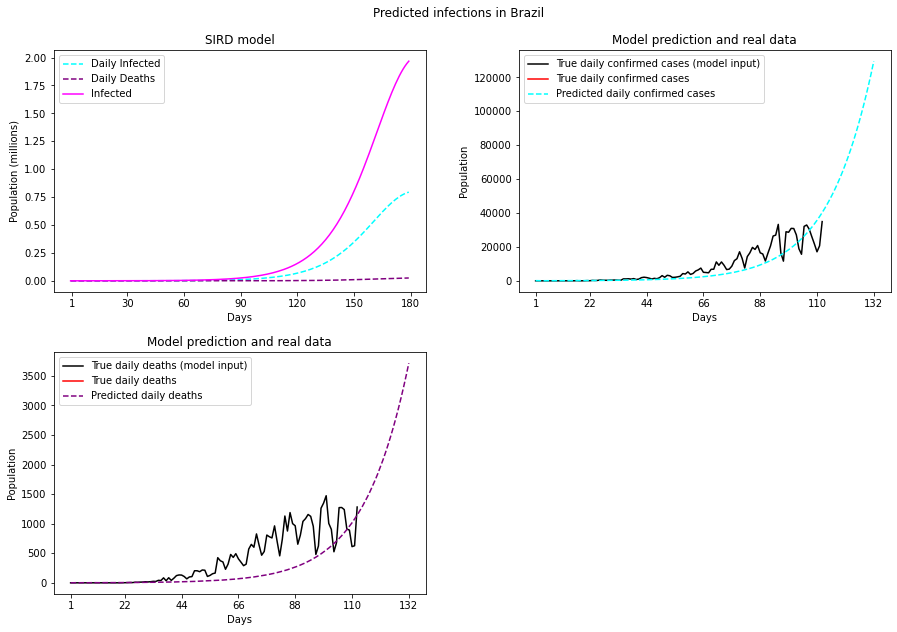

In [30]:
fig, ax1, ax2, ax3 = model.plot_predictions(
    n_days=180, x=x_brazil_daily, y_true=y_brazil_daily,
    title='Predicted infections in Brazil')